In [1]:
%load_ext autoreload
%autoreload 2

import fine_tune.train

/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Segment Anything custom imported


In [2]:
cfg = None
dataset = None

In [3]:
import os
# set DATASET_DIRECTORY env var to "datasets/"
os.environ["DATASET_DIRECTORY"] = "datasets"

from fine_tune.configs.climbing import *

assert cfg is not None,"Must set config"
assert dataset is not None,"Must set training dataset"

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to datasets/Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2985.98it/s]


In [4]:
import torch
seed = 5
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from fine_tune.load_datasets import load_datasets

train_dataset,valid_dataset = load_datasets(cfg.data,dataset)

Selecting classes ['climbing-holds', 'floor', 'person']


In [7]:
from fine_tune.models import WrappedSamModel

sam = WrappedSamModel(cfg).to(device)

encoder = sam.encoder
decoder = sam.decoder
predictor = sam.predictor

{}
warm started


In [8]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [9]:
import torch

run_num = None

if run_num is not None:
    sam.load_state_dict(torch.load(f"runs/{run_num}/trainable.pt"))

In [10]:
from fine_tune.load_datasets import prepare_torch_dataset

print(cfg.data.points_per_mask)

curr_dataset = prepare_torch_dataset(predictor,cfg,train_dataset,max_prompts=cfg.data.train_prompts)
valid_curr_dataset = prepare_torch_dataset(predictor,cfg,valid_dataset,max_prompts=cfg.data.valid_prompts)

[1, 20, 20]


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 81840.08it/s]


In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
import numpy as np

from numpy.random import permutation
from tqdm import tqdm
import json

from fine_tune.common import SamDataset,get_max_iou_masks,to
from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt


In [12]:
from PIL import Image
import numpy as np

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0

    running_cls_loss = 0.0
    running_cls_count = 0
    
    sam.eval()

    for batch in tqdm(valid_curr_dataset):

        batch = to(batch,device)
        prompt_input, gt_info, gt_cls_info, imgs,sizes, prompt = batch

        use_cls = cfg.model.decoder.use_cls and gt_cls_info is not None

        with torch.no_grad():
            encoder_output = encoder.get_decoder_input(imgs,prompt)

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

            _,losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)

            normal_loss = losses["loss"]
            running_loss += normal_loss.item()
            running_count += 1

            cls_loss = losses["cls_loss"]
            running_cls_loss += cls_loss.item()
            running_cls_count += 1

            if use_cls:
                # get pred gt class
                (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)

                _,_,_,best_cls,_ = get_max_iou_masks(gt_info["masks"],cls_binary_masks,gt_cls_info["gt_cls"],torch.arange(cfg.data.num_classes).to(device))

                pred_classes.append(pred_cls)
                gt_classes.append(best_cls)

    valid_loss = running_loss/running_count
    valid_cls_loss = running_cls_loss/running_cls_count

    print(f"VALID - Base loss: {valid_loss:.4f} - Class loss: {valid_cls_loss:.4f}")

    wandb.log({
        "valid_normal_loss": valid_loss,
        "valid_cls_loss": valid_cls_loss,
    })

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [13]:
from fine_tune.optimizer import get_optimizer

optimizer,scheduler = get_optimizer(cfg,sam)

Total trainable parameters: 552803


100%|██████████| 200/200 [00:15<00:00, 12.54it/s]


VALID - Base loss: 0.4479 - Class loss: 1.5292


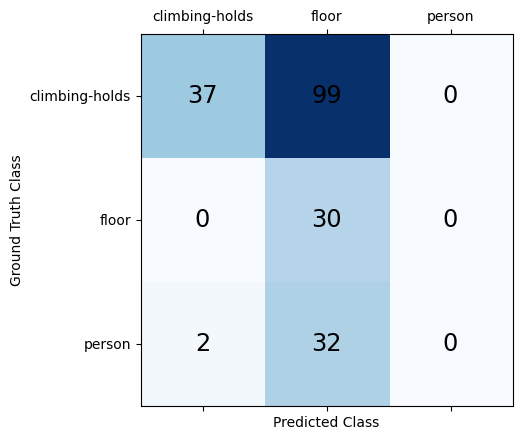

  0%|          | 4/7205 [00:00<07:37, 15.75it/s]

Loss: 1.2105023860931396


  3%|▎         | 202/7205 [00:15<09:04, 12.86it/s]

Loss: 1.4695081025362016


  6%|▌         | 402/7205 [00:30<09:46, 11.60it/s]

Loss: 0.98685970030725


  8%|▊         | 604/7205 [00:46<07:21, 14.94it/s]

Loss: 0.9523103924840689


 11%|█         | 803/7205 [01:02<07:37, 14.01it/s]

Loss: 0.760587221160531


 14%|█▍        | 1004/7205 [01:17<06:46, 15.27it/s]

Loss: 0.6784604353085161


 17%|█▋        | 1204/7205 [01:30<04:35, 21.80it/s]

Loss: 0.733083042614162


 19%|█▉        | 1403/7205 [01:42<06:08, 15.75it/s]

Loss: 0.6030780902504921


 22%|██▏       | 1602/7205 [01:58<09:27,  9.87it/s]

Loss: 0.6109292151778937


 25%|██▌       | 1803/7205 [02:09<04:23, 20.53it/s]

Loss: 0.5057327552139759


 28%|██▊       | 2004/7205 [02:19<04:05, 21.16it/s]

Loss: 0.5378251801803708


 31%|███       | 2202/7205 [02:29<04:17, 19.42it/s]

Loss: 0.6489257685467601


 33%|███▎      | 2403/7205 [02:39<04:07, 19.40it/s]

Loss: 0.5785300108231604


 36%|███▌      | 2603/7205 [02:49<03:41, 20.77it/s]

Loss: 0.5795753864757717


 39%|███▉      | 2802/7205 [02:59<04:34, 16.04it/s]

Loss: 0.41838839747011664


 42%|████▏     | 3004/7205 [03:09<03:21, 20.83it/s]

Loss: 0.616095795147121


 44%|████▍     | 3202/7205 [03:21<03:38, 18.28it/s]

Loss: 0.5535672072693706


 47%|████▋     | 3403/7205 [03:32<03:48, 16.63it/s]

Loss: 0.46524341993033885


 50%|█████     | 3604/7205 [03:43<02:58, 20.21it/s]

Loss: 0.49884717965498565


 53%|█████▎    | 3802/7205 [03:53<02:53, 19.62it/s]

Loss: 0.42621741397306323


 56%|█████▌    | 4004/7205 [04:04<02:32, 21.00it/s]

Loss: 0.47841267004609106


 58%|█████▊    | 4202/7205 [04:14<02:31, 19.83it/s]

Loss: 0.43428540861234066


 61%|██████    | 4403/7205 [04:24<02:23, 19.48it/s]

Loss: 0.44792041881009936


 64%|██████▍   | 4604/7205 [04:34<01:59, 21.68it/s]

Loss: 0.4531969984062016


 67%|██████▋   | 4802/7205 [04:44<02:01, 19.71it/s]

Loss: 0.4320005636103451


 69%|██████▉   | 5004/7205 [04:54<01:42, 21.53it/s]

Loss: 0.5789546435140074


 72%|███████▏  | 5203/7205 [05:05<01:35, 21.07it/s]

Loss: 0.4163940510340035


 75%|███████▌  | 5404/7205 [05:15<01:24, 21.23it/s]

Loss: 0.4196312182210386


 78%|███████▊  | 5604/7205 [05:25<01:13, 21.79it/s]

Loss: 0.43962544726207853


 81%|████████  | 5802/7205 [05:35<01:13, 18.99it/s]

Loss: 0.4264235675893724


 83%|████████▎ | 6003/7205 [05:45<00:54, 22.08it/s]

Loss: 0.36670353515073656


 86%|████████▌ | 6203/7205 [05:55<00:48, 20.75it/s]

Loss: 0.41253182537853716


 89%|████████▉ | 6402/7205 [06:05<00:40, 19.99it/s]

Loss: 0.4077683738619089


 92%|█████████▏| 6602/7205 [06:15<00:29, 20.11it/s]

Loss: 0.41668285382911563


 94%|█████████▍| 6802/7205 [06:25<00:20, 19.23it/s]

Loss: 0.42021065566688776


 97%|█████████▋| 7003/7205 [06:35<00:09, 21.70it/s]

Loss: 0.35284017492085695


100%|██████████| 7205/7205 [06:45<00:00, 17.75it/s]

Loss: 0.468355725761503



100%|██████████| 200/200 [00:08<00:00, 23.17it/s]


VALID - Base loss: 0.4479 - Class loss: 0.4761


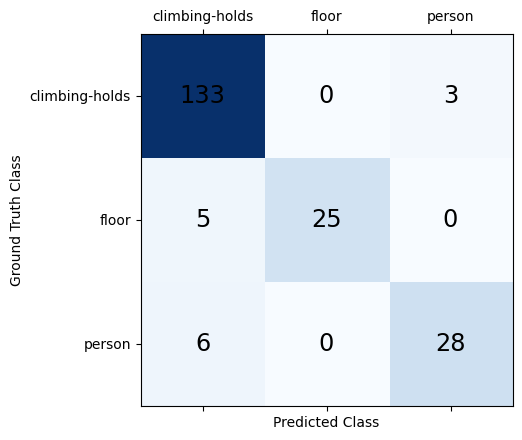

  3%|▎         | 200/7205 [00:10<06:02, 19.33it/s]

Loss: 0.4350404148176312


  6%|▌         | 398/7205 [00:20<05:26, 20.84it/s]

Loss: 0.389950997363776


  8%|▊         | 599/7205 [00:29<05:07, 21.49it/s]

Loss: 0.3723890601657331


 11%|█         | 800/7205 [00:40<05:24, 19.75it/s]

Loss: 0.40485878819599747


 14%|█▍        | 999/7205 [00:49<04:54, 21.09it/s]

Loss: 0.4540397490002215


 17%|█▋        | 1197/7205 [00:59<05:00, 20.01it/s]

Loss: 0.41957465596497057


 19%|█▉        | 1398/7205 [01:09<04:37, 20.90it/s]

Loss: 0.4230954605899751


 22%|██▏       | 1599/7205 [01:19<04:20, 21.55it/s]

Loss: 0.41225285386666655


 25%|██▍       | 1797/7205 [01:29<04:32, 19.84it/s]

Loss: 0.4318787634372711


 28%|██▊       | 1998/7205 [01:39<04:09, 20.89it/s]

Loss: 0.4125870494171977


 31%|███       | 2199/7205 [01:49<04:05, 20.39it/s]

Loss: 0.3422093083895743


 33%|███▎      | 2397/7205 [01:59<04:06, 19.51it/s]

Loss: 0.4007285175472498


 36%|███▌      | 2597/7205 [02:09<03:49, 20.10it/s]

Loss: 0.37531363755464553


 39%|███▉      | 2798/7205 [02:19<03:32, 20.78it/s]

Loss: 0.3950172930769622


 42%|████▏     | 2999/7205 [02:29<03:22, 20.73it/s]

Loss: 0.3978714263718575


 44%|████▍     | 3197/7205 [02:39<03:18, 20.20it/s]

Loss: 0.3236880632862449


 47%|████▋     | 3398/7205 [02:48<02:56, 21.53it/s]

Loss: 0.3459999457374215


 50%|████▉     | 3599/7205 [02:58<02:43, 22.00it/s]

Loss: 0.4030280689895153


 53%|█████▎    | 3799/7205 [03:09<02:40, 21.23it/s]

Loss: 0.32702608868479727


 56%|█████▌    | 3999/7205 [03:19<02:23, 22.41it/s]

Loss: 0.41639678936451674


 58%|█████▊    | 4198/7205 [03:29<02:19, 21.62it/s]

Loss: 0.44895105803385377


 61%|██████    | 4399/7205 [03:38<02:10, 21.56it/s]

Loss: 0.3237691041827202


 64%|██████▍   | 4598/7205 [03:48<02:00, 21.63it/s]

Loss: 0.40155938897281884


 67%|██████▋   | 4800/7205 [03:58<01:52, 21.45it/s]

Loss: 0.28291555736213925


 69%|██████▉   | 4998/7205 [04:08<01:42, 21.63it/s]

Loss: 0.25096818124875425


 72%|███████▏  | 5199/7205 [04:18<01:28, 22.65it/s]

Loss: 0.3379864394851029


 75%|███████▍  | 5400/7205 [04:27<01:29, 20.28it/s]

Loss: 0.41340288799256086


 78%|███████▊  | 5599/7205 [04:37<01:13, 22.00it/s]

Loss: 0.30721333015710117


 80%|████████  | 5797/7205 [04:46<01:09, 20.38it/s]

Loss: 0.35933810628950597


 83%|████████▎ | 6000/7205 [04:56<01:00, 20.06it/s]

Loss: 0.3473617052473128


 86%|████████▌ | 6199/7205 [05:06<00:46, 21.62it/s]

Loss: 0.4495284565724432


 89%|████████▉ | 6397/7205 [05:16<00:39, 20.37it/s]

Loss: 0.42891294859349727


 92%|█████████▏| 6598/7205 [05:25<00:27, 21.74it/s]

Loss: 0.31221726436167957


 94%|█████████▍| 6797/7205 [05:35<00:20, 20.30it/s]

Loss: 0.3166425294149667


 97%|█████████▋| 6998/7205 [05:45<00:09, 21.64it/s]

Loss: 0.3972340748272836


100%|█████████▉| 7197/7205 [05:54<00:00, 19.06it/s]

Loss: 0.3815343757160008


100%|██████████| 7205/7205 [05:55<00:00, 20.28it/s]


In [14]:
from dataclasses import asdict

run = wandb.init(
    project="sam-fine-tune",
    config=asdict(cfg)
)

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []

curr_epoch = 0

# iter through dataset in random order
while curr_iters < cfg.train.max_steps:
    evaluate()
    sam.train()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):

        with torch.no_grad():
            prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = to(curr_dataset[idx],device)
        
        use_cls_loss = gt_cls_info is not None and cfg.model.decoder.use_cls
        
        has_fresh_prompt = True
        refinements_remaining = cfg.train.num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            encoder_output = encoder.get_decoder_input(imgs,prompt)
            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)


            #
            # WandB
            #
            
            loss,loss_dict = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)

            input_img_torch = imgs[2]
            image_embeddings= encoder_output["image_embeddings"]

            loss_dict = {k:v.item() for k,v in loss_dict.items()}
            wandb.log(loss_dict)

            #
            # Logging
            #

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-cfg.train.log_period:]

            if curr_iters % cfg.train.eval_period == 0:
                evaluate()
                sam.train()

            if curr_iters % cfg.train.log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            curr_iters += 1

            if not cfg.train.run_grad: continue

            accumulated_loss += loss
            if curr_iters % cfg.train.batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= torch.tensor(cfg.train.batch_size,dtype=torch.float32)
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0
            
            scheduler.step()

            #
            # Progressive refinement
            #

            if refinements_remaining > 0:

                raise NotImplementedError("Need to update this to use new training system")

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

In [15]:
sam.eval()
1

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to datasets/Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 3485.74it/s]


1

In [16]:
from glob import glob
import os

runs_dir = "runs_new"
run_ids = [int(fname) for fname in os.listdir(runs_dir)]
highest_run = max(run_ids) if len(run_ids) > 0 else 0
run_num = highest_run + 1
export_dir = f"{runs_dir}/{run_num}"
!mkdir -p $export_dir
print(f"Run saved to {export_dir}")

from fine_tune.export import export

export(export_dir,cfg,sam,device)

Run saved to runs_new/20
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



INFO:root:Quantization parameters for tensor:"/Sub_output_0" not specified
INFO:root:Quantization parameters for tensor:"mask_input" not specified
INFO:root:Quantization parameters for tensor:"/mask_downscaling/mask_downscaling.2/Mul_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/mask_downscaling/mask_downscaling.5/Mul_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/Add_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Concat_6_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/self_attn/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/Add_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/Transpose_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/cross_attn_token_to_image/Reshape_3_output_0" not specified
INFO:root:Quantizati

Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token/MatMul_1]


INFO:root:Quantization parameters for tensor:"/transformer/layers.1/Add_2_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/self_attn/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/Add_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/norm4/LayerNormalization_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/cross_attn_token_to_image/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/norm2/LayerNormalization_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/mlp/act/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/Add_5_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.1/norm3/LayerNormalization_output_0" not specified


Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul]


INFO:root:Quantization parameters for tensor:"/transformer/layers.1/cross_attn_image_to_token/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Concat_12_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/self_attn_1/Reshape_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0_1/Add_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/cross_attn_token_to_image_1/Reshape_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/norm2_1/LayerNormalization_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/mlp/act_1/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0_1/Add_3_output_0" not specified
INFO:root:Quantization parameters for tensor:"/transformer/layers.0/norm3_1/LayerNormalization_output_0" not specified
INFO

Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_image_to_token/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn_1/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/self_attn_1/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image_1/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_token_to_image_1/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token_1/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.0/cross_attn_image_to_token_1/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn_1/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/self_attn_1/MatMul_1]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image_1/MatMul]
Ignore MatMul due to non constant B: /[/transformer/layers.1/cross_attn_token_to_image

INFO:root:Quantization parameters for tensor:"/output_hypernetworks_mlps.2/Relu_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Gather_7_output_0" not specified
INFO:root:Quantization parameters for tensor:"/output_hypernetworks_mlps.1/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/output_hypernetworks_mlps.1/Relu_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Gather_6_output_0" not specified
INFO:root:Quantization parameters for tensor:"/output_hypernetworks_mlps.0/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/output_hypernetworks_mlps.0/Relu_1_output_0" not specified
INFO:root:Quantization parameters for tensor:"/Gather_5_output_0" not specified
INFO:root:Quantization parameters for tensor:"/iou_prediction_head/Relu_output_0" not specified
INFO:root:Quantization parameters for tensor:"/iou_prediction_head/Relu_1_output_0" not specified
INFO:root:Quantization parameters for te

Ignore MatMul due to non constant B: /[/MatMul_1]


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:08<00:00, 22.86it/s]


VALID - Base loss: 0.4479 - Class loss: 0.4613


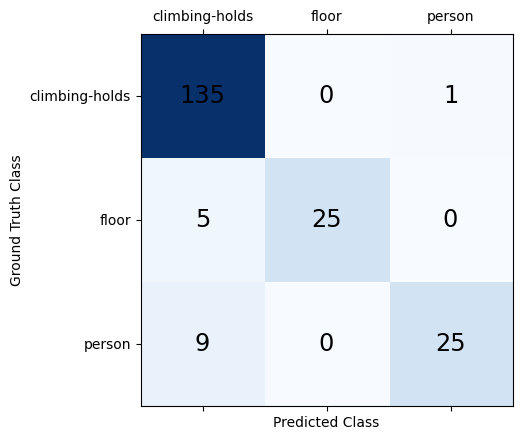

In [17]:
evaluate()

Loss: 0.9380943775177002
Predicted IoU: 0.6575078964233398 real IoU: 0.3504562973976135


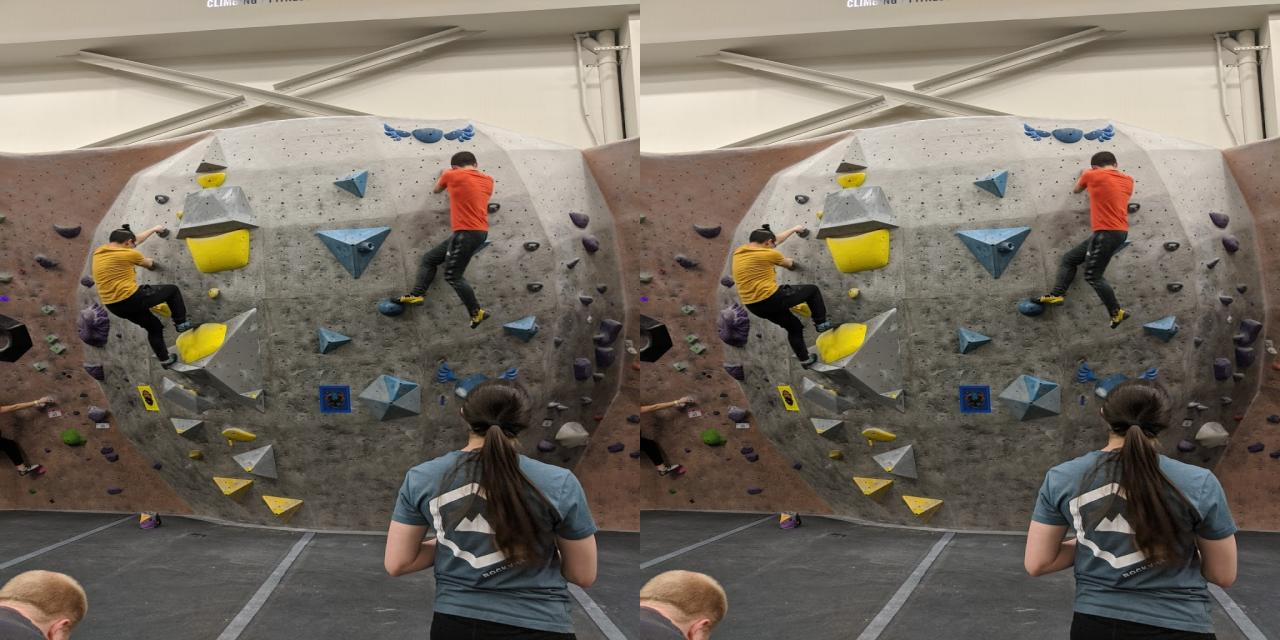

Cls loss: 0.18239648640155792
Predicted cls: 0 GT cls: 0
Predicted cls IoU: 0.6575078964233398 real cls IoU: 0.3504562973976135


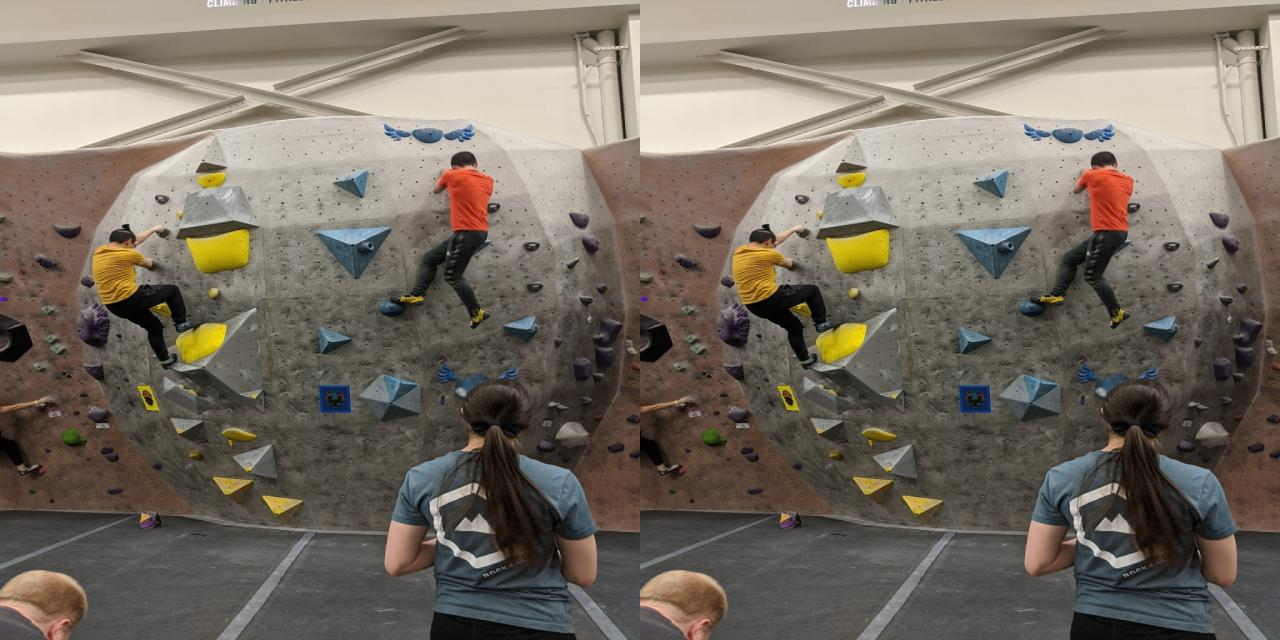

In [18]:
from random import randint

v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = to(v_c_ds[idx],device)

gt_masks = gt_info["masks"]
gt_cls = gt_cls_info["gt_cls"]

use_normal_tokens = True
use_cls_tokens = cfg.model.decoder.use_cls and gt_cls_info is not None

has_fresh_prompt = True
num_refinements_left = cfg.train.num_refinement_steps
while has_fresh_prompt:
    has_fresh_prompt = False

    with torch.no_grad():
        encoder_output = encoder.get_decoder_input(imgs,prompt)
        low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

        loss,losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
        
        (upscaled_masks,binary_masks),max_idx = decoder.postprocess(low_res_masks,iou_predictions,sizes)
        pred_iou = F.sigmoid(iou_predictions[0,max_idx]).item()
        binary_mask = binary_masks[max_idx]

        gt_binary_mask, _, _, _, _ = get_max_iou_masks(gt_masks,binary_mask[None,...])

        if use_cls_tokens:

            (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)
            cls_binary_mask = cls_binary_masks[pred_cls,...]

            # get focal and dice loss between cls_binary_mask and closest gt mask
            cls_gt_binary_mask,_,max_iou,best_cls,_ = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(cfg.data.num_classes).to(device))

        if num_refinements_left > 0:
            raise NotImplementedError("Need to update this to use new training system")

            has_fresh_prompt = True
            num_refinements_left -= 1

from PIL import Image

img = imgs[0]

if use_normal_tokens:
    print("Loss:",losses["loss"].item())
    print("Predicted IoU:",pred_iou,"real IoU:",max_iou.item())

    clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

# print cls loss
if use_cls_tokens:
    print("Cls loss:",losses["cls_loss"].item())
    print("Predicted cls:",pred_cls.item(),"GT cls:",gt_cls.item())
    print("Predicted cls IoU:",pred_iou,"real cls IoU:",max_iou.item())

    clip_together_imgs(mask_to_img(cls_binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

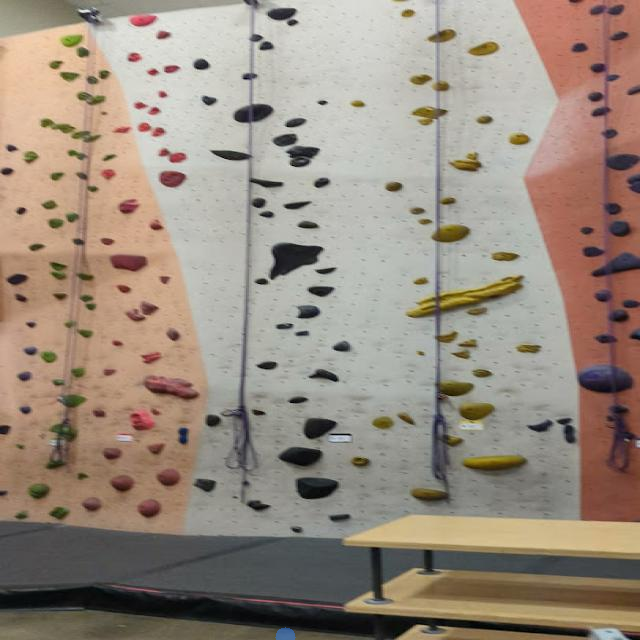

In [19]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
render_prompt(name,prompt,train_dataset)